# More on Neural Networks

In [2]:
import numpy as np  # Fast math and arrays
import matplotlib.pyplot as plt  # Displays
import matplotlib.colors as colors  # colors
import matplotlib.cm as cmx  # Colormaps

%matplotlib inline  

## Feedforward neural networks

To alleviate the problems of perceptrons, we need to complicate our networks in two ways:

1. First, introducing non-linear activation functions
2. Second, adding a new layer (the _hidden_ layer) between input and output

The most common non-linear activation functions are the _sigmoid_ function and the hyperbolic tangent (_tanh_) function.

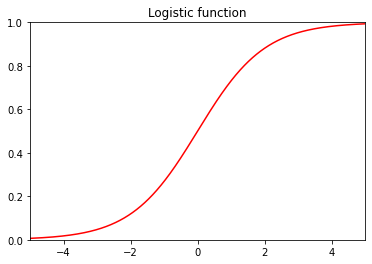

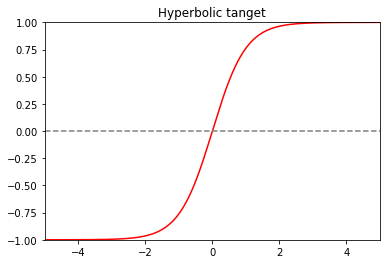

In [3]:
x = np.arange(-500, 500)/100.0

def logistic(x, gain = 1.0):
    """Sigmoid logistic function"""
    return 1 / (1 + np.exp(-x * gain))

def hypertan(x, gain = 1.0):
    """Hyperbolic tangent"""
    return np.tanh(x * gain)

y1 = [logistic(j) for j in x]
ymin, ymax = (0, 1)
plt.axis([-5, 5, ymin, ymax])
plt.plot(x, y1, 'red')
plt.title("Logistic function")
plt.show()

y2 = [hypertan(j) for j in x]
ymin, ymax = (-1, 1)
plt.axis([-5, 5, ymin, ymax])
plt.plot(x, y2, 'red')
plt.plot([-5, 5], [0, 0], "--", color="grey")
plt.title("Hyperbolic tanget")
plt.show()

## Backpropagation

Backpropagation is a generalization of the gradient descent algorithm. 

To calculate the gradient, we apply the chain rule twice:

$$
\frac{\partial E}{\partial w_{i,j}} = \frac{\partial E}{\partial y_j}  \frac{\partial y_j}{\partial \textrm{in}_j}  \frac{\partial \textrm{in}_j}{\partial w_{i,j}}
$$

where $in_j$ is the net (summed) input to neuron $j$, and $y_j$ is its output: $y_j = f(\textrm{in}_j)$

Now, we can consider these three factors separately.  

The second factor is the derivative of the activation function

$$
\begin{aligned}
\frac{\partial y_j}{\partial \textrm{in}_j} &= \frac{\partial f(\textrm{in}_j)}{\partial \textrm{in}_j} \\
&= f'(\textrm{in}_j) 
\end{aligned}
$$

And the third factor the output of the pre-synaptic neuron:

$$
\begin{aligned}
\frac{\partial \textrm{in}_j}{\partial w_{i,j}} &= \frac{\partial \sum_k w_{k,j}y_k}{\partial w_{i,j}} \\
&= y_i
\end{aligned}
$$

Now, the first factor is the error with respect to the output. In the case of the output layer, this can be calculated directly. But how about the middle layer(s)?

The intuition is that $\frac{\partial E}{\partial y_j}$ can be calculated recursively. If we know the error of the layer below, we know how the error is affected by changes of $y_j$! in fact, that can be calculated as...

$$
\frac{\partial E}{\partial y_j} = \sum_k (\frac{\partial E}{\partial o_k} \frac{\partial o_k}{\partial \textrm{in}_k} w_{j,k})
$$

Because we can measure exactly the error of the bottom (output) layer, we can recurively calculate the error in the upper layer by multiplying it by the synpatic layer in between.

And that, of course, how backpropagation got its name: We are propagating back the error through the synaptic matrices!  

/home/andrea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead


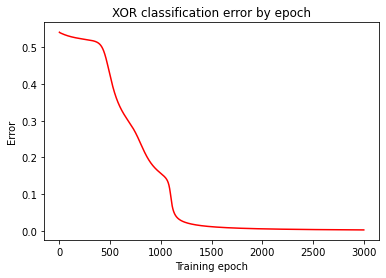

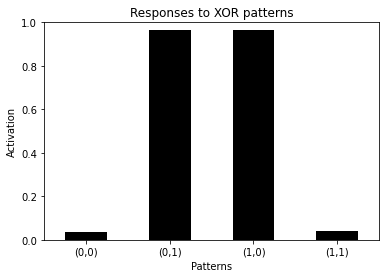

In [12]:
# A Feedforward neural network solving the XOR problem with backprop.

n_input  = 2
n_hidden = 5
n_output = 1

x  = np.zeros((1, n_input))                              # Input values
w1 = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
h  = np.zeros((1, n_hidden))                              # Hidden layer
w2 = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses

eta = 1.0   # Learning rate. This is higher than usual.

# The patterns to learn

patterns = [[0, 0], [0, 1], [1, 0], [1, 1]]

# Redefining some crucial functions

def logistic(x, deriv = False):
    """Sigmoid logistic function (with derivative)"""
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

    
def set_inputs(vals):
    """Sets a given XOR pattern into the input value"""
    global x
    x = np.array(vals).reshape((1,2))
    
    
def activation():
    """Spreads activation through a network"""
    global h
    
    # First pass, from input to hidden layer
    h_input = np.dot(x, w1)
    h = logistic(h_input)
    
    # Second pass, from input layer to output
    output_input = np.dot(h, w2)
    return logistic(output_input)

def calculate_response(digit):
    """Calculates the response of the neuron to a digit"""
    set_inputs(digit)
    return activation()

def target(val):
    """Desired response function, t(p)"""
    if  np.all(val == np.array([0, 1])) or np.all(val == np.array([1, 0])):
        return 1.0
    else:
        return 0.0

def error(i, response):
    """Calculates the error function"""
    return 0.5 * ((target(i) - response) ** 2)
    
def backprop(n = 1):
    """Performs the backpropagation algorithm over N epochs, returns error function"""
    E = []
    global w1
    global w2
    for i in np.arange(n):
        e = 0.0

        for p in patterns:
            o = calculate_response(p)
            e += error(p, o)
            
            # Error in output layer
            o_error = target(p) - o
            do = o_error * logistic(o, deriv = True)
            
            # error in hidden layer
            h_error = np.dot(do, w2.T) 
            dh = h_error * logistic(h, deriv = True)
            
            dw2 = np.dot(h.T, do) 
            dw1 = np.dot(x.T, dh)
            
            w2 += eta * dw2
            w1 += eta * dw1
        
        E.append(np.asscalar(e))  # Error at epoch i 
    return E  # Returns the list of error by epoch
            

# Plot the error function by epoch
plt.plot(backprop(3000), "r-")
plt.xlabel("Training epoch")
plt.ylabel("Error")
plt.title("XOR classification error by epoch")
plt.show()

# Plot the responses to the XOR patterns
y_end = [calculate_response(p) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, 3.5, 0, 1])
ax.set_xticks(np.arange(4))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(4), [float(x) for x in y_end], 0.5, color='black')
ax.set_title("Responses to XOR patterns")
plt.show()

# Solutions

These are possiblesolutions to the original perceptron network from notebook 1. 

### The variables 

In [69]:
target_num = 7

### The code

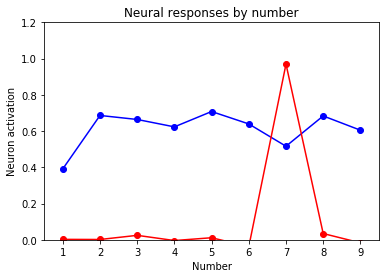

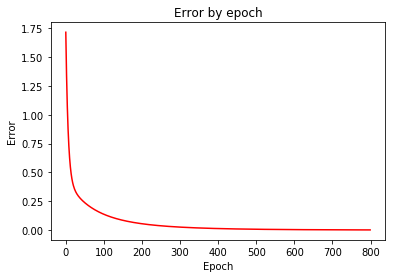

In [70]:
num = np.loadtxt("7.txt")  # Load the corresponding file , 1...9.txt
vals = np.arange(1, 10)

x = np.zeros((num.size))                # Input values
w = np.random.random((num.size)) / 10   # Synapses
eta = 0.01  # Learning rate


def set_inputs(digit):
    """Loads the inputs corresponding to a digit into the input values"""
    global x
    if digit >= 1 and digit < 10:
        x = np.loadtxt("%s.txt" % digit).flatten()
        
def activation():
    """Linear activation rule"""
    inputs = w * x
    return sum(inputs)

def calculate_response(digit):
    """Calculates the response of the neuron to a digit"""
    set_inputs(digit)
    return activation()


def target(i):
    """Desired response function, t(p)"""
    if i == target_num:
        return 1.0
    else:
        return 0.0
    
def error(i, response):
    """Calculates the error function"""
    return 0.5 * ((target(i) - response) ** 2)
    
def gradient_descent(n = 1):
    """Performs the gradient descent algorithm over N epochs"""
    global w
    for i in np.arange(n):
        dw = np.zeros(w.shape)  # General dW = 0.
        e = 0.0 
        for j in vals:  # For every number in our set
            y = calculate_response(j)
            e += error(j, y)  # Calculate the error
            #dwj = x * (target(j) - y)
            dwj = x.reshape(28, 1).dot(target(j) -y)
            dwj = dwj / len(vals)   # Increments dW with this number's results
            dw += dwj.reshape(dw.shape)
        
        E.append(e)
        w += eta * dw  # updates W

target_num = 7
E = []  # Error by epoch

w = np.random.random(num.size)/10   # Synapses

ys_start = [calculate_response(j) for j in vals]

plt.axis([0.5, 9.5, 0, 1.2])
plt.plot(vals, ys_start, "bo-")

gradient_descent(n = 800)

ys_end = [calculate_response(j) for j in vals]
plt.plot(vals, ys_end, "ro-")
plt.title("Neural responses by number")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

plt.plot(E, "r-")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Error by epoch")
plt.show()

### New solution

In this solution, we simply modify the target response function $t(n)$, so that the desired response to a number $n$ is simply a a decimal number $n/10$:

In [71]:
def target(i):
    """New desired response function"""
    return i/10.0

With this solution in place, we can run the same simulations

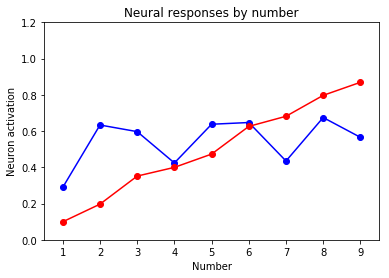

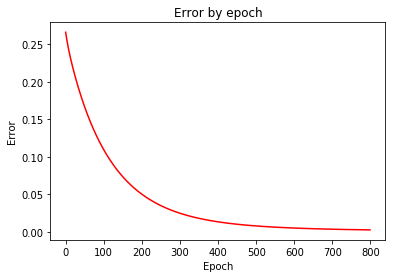

In [72]:
E = []  # Error by epoch

w = np.random.random(num.size)/10   # Synapses

ys_start = [calculate_response(j) for j in vals]

plt.axis([0.5, 9.5, 0, 1.2])
plt.plot(vals, ys_start, "bo-")

gradient_descent(n = 800)

ys_end = [calculate_response(j) for j in vals]
plt.plot(vals, ys_end, "ro-")
plt.title("Neural responses by number")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

plt.plot(E, "r-")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.title("Error by epoch")
plt.show()

### Multiple response unit solution

Another solution, a bit more complicated, requires modifying the network so that our 28 input units are mapped to 9 output units, one for each number 1..9. In turn, this requires defining the synaptic layer as a 28x9 matrix between 28 input units and 9 response units. 

In [73]:
w = np.random.random((num.size, 9)) / 10   # Synapses

A few functions need to be redefined to adapt to this new format. 

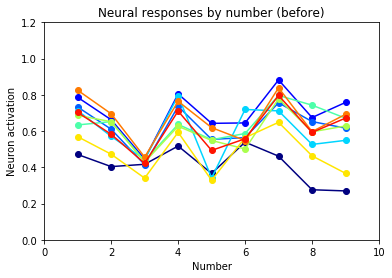

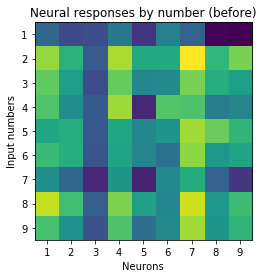

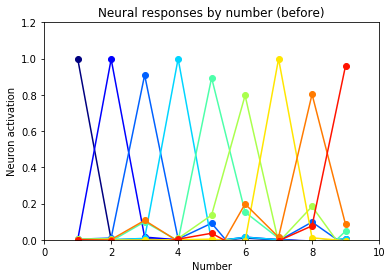

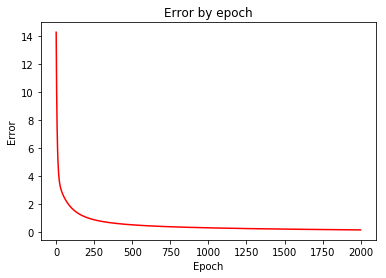

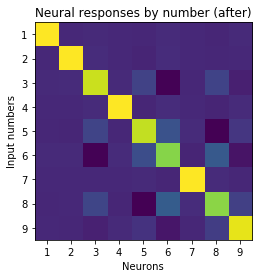

In [74]:
def activation():
    """Linear activation rule"""
    z = x.reshape((1, 28))
    inputs = z.dot(w)
    return inputs

def calculate_response(digit):
    """Calculates the response of the neuron to a digit"""
    set_inputs(digit)
    return activation()


def target(i):
    """Desired response function, t(p)"""
    z = np.zeros((9))
    z[i-1] = 1
    return z
    
def error(i, response):
    """Calculates the error function"""
    return 0.5 * np.sum(((target(i) - response) ** 2))

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin = 0, vmax = len(vals))
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = jet)

E = []  # Error by epoch

for j in vals:
    ys = calculate_response(j)
    plt.plot(vals, ys.reshape(9).tolist(), "o-", color=scalarMap.to_rgba(j-1))
    
plt.axis([0,10,0,1.2])
plt.title("Neural responses by number (before)")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

ys = np.zeros((9,9))
for j in vals:
    y = calculate_response(j)
    ys[j-1] = y
    
plt.imshow(ys, interpolation="none")
plt.title("Neural responses by number (before)")
plt.xlabel("Neurons")
plt.ylabel("Input numbers")
plt.xlabel("Neurons")
plt.xticks(vals -1, vals)
plt.ylabel("Input numbers")
plt.yticks(vals -1, vals)
plt.show()

gradient_descent(n = 2000)

for j in vals:
    ys = calculate_response(j)
    plt.plot(vals, ys.reshape(9).tolist(), "o-", color=scalarMap.to_rgba(j-1))
    
plt.axis([0,10,0,1.2])
plt.title("Neural responses by number (before)")
plt.xlabel("Number")
plt.ylabel("Neuron activation")
plt.show()

plt.plot(E, color="red")
plt.title("Error by epoch")
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

ys = np.zeros((9,9))
for j in vals:
    y = calculate_response(j)
    ys[j-1] = y
    
plt.imshow(ys, interpolation='none')
plt.title("Neural responses by number (after)")
plt.xlabel("Neurons")
plt.xticks(vals -1, vals)
plt.ylabel("Input numbers")
plt.yticks(vals -1, vals)
plt.show()


# More neural networks

Let's continue our work with neural networks

## The power of neural networks

The power of feedforward neural networks comes from the use of nonlinear activation functions and hidden layers. The hidden layers are the most important part; they expand the dimensionality of the inputs, making it possible to separate them into classes.

For example, let's reconsider the XOR network with backpropagation, only this time with linear functions.

### Variables for the network

In [75]:
n_input  = 2
n_hidden = 20
n_output = 1
eta = 0.5   # Learning rate. This is higher than usual.
epochs = 5000

# The patterns to learn

patterns = [[0, 0], [0, 1], [1, 0], [1, 1]]

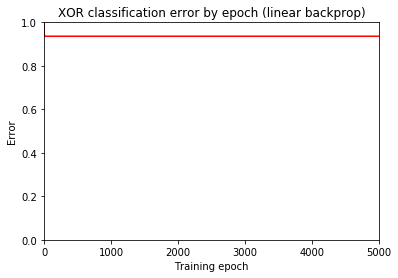

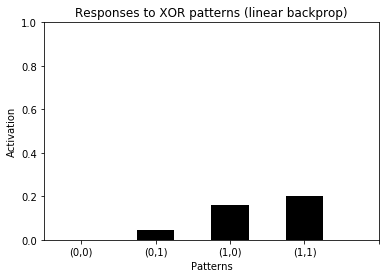

In [76]:
# A Feedforward neural network solving the XOR problem with backprop.

x  = np.zeros((1, n_input))                              # Input values
w1 = (np.random.random((n_input, n_hidden)) / 5) - 0.1    # First layer of synapses
h  = np.zeros((1, n_hidden))                              # Hidden layer
w2 = (np.random.random((n_hidden, n_output)) / 5) - 0.1   # Second layer of synapses


# Redefining some crucial functions

def calculate_response(digit):
    """Calculates the response of the neuron to a digit"""
    set_inputs(digit)
    return activation()

def linear(x, deriv = False):
    """Linear activation function (with derivative)"""
    if deriv:
        return 1.0
    else:
        return x

def logistic(x, deriv = False):
    """Sigmoid logistic function (with derivative)"""
    if deriv:
        return x * (1 - x)
    else:
        return 1 / (1 + np.exp(-x))

def set_inputs(vals):
    """Sets a given XOR pattern into the input value"""
    global x
    x = np.array(vals).reshape((1,2))
    
    
def activation():
    """Spreads activation through a network"""
    global h
    
    # First pass, from input to hidden layer
    h_input = np.dot(x, w1)
    h = linear(h_input)
    
    # Second pass, from input layer to output
    output_input = np.dot(h, w2)
    return linear(output_input)


def target(val):
    """Desired response function, t(p)"""
    if  np.all(val == np.array([0, 1])) or np.all(val == np.array([1, 0])):
        return 1.0
    else:
        return 0.0

def error(i, response):
    """Calculates the error function"""
    return 0.5 * ((target(i) - response) ** 2)

    
def backprop(n = 1):
    """Performs the backpropagation algorithm over N epochs, returns error function"""
    E = []
    global w1
    global w2
    for i in np.arange(n):
        e = 0.0

        for p in patterns:
            o = calculate_response(p)
            e += error(p, o)
            
            # Error in output layer
            o_error = target(p) - o
            do = o_error * linear(o, deriv = True)
            
            # error in hidden layer
            h_error = np.dot(do, w2.T) 
            dh = h_error * linear(h, deriv = True)
            
            # If you had other layers, we could go on and on...
            
            dw2 = np.dot(h.T, do) 
            dw1 = np.dot(x.T, dh)
            
            w2 += eta * dw2
            w1 += eta * dw1
        
        E.append(np.asscalar(e))  # Error at epoch i 
    return E  # Returns the list of error by epoch
            

# Plot the error function by epoch
plt.plot(backprop(epochs), "r-")
plt.xlabel("Training epoch")
plt.ylabel("Error")
plt.axis([0, epochs, 0, 1])
plt.title("XOR classification error by epoch (linear backprop)")
plt.show()

# Plot the responses to the XOR patterns
y_end = [calculate_response(p) for p in patterns]
fig, ax = plt.subplots()
ax.axis([-0.5, 3.5, 0, 1])
ax.set_xticks(np.arange(5))
ax.set_xticklabels(["(%s,%s)" % tuple(p) for p in patterns])
ax.set_ylabel("Activation")
ax.set_xlabel("Patterns")
ax.bar(np.arange(4), [float(y) for y in y_end], 0.5, color='black')
ax.set_title("Responses to XOR patterns (linear backprop)")
plt.show()

In [77]:
# Autoassociator

n_x1 = 10
n_x2 = 10

x1 = np.zeros((1, n_x1))
x2 = np.zeros((1, n_x2))
w = np.random.random((n_x1, n_x2))

 

## Classic conditioning with Hebb rule

This is a model of the classic experiment whereby the eyeblink response a rabbit, normally elicited by _unconditioned stimulus_ of an air puff,  becomes a _conditioned response_ to a the _conditioned stimulus_ of a tone. 

First, the network setup

In [78]:
tone = 1
swab = 1
blink = 1

no_tone = 0
no_swab = 0
no_blink = 0

x_tone = 0
x_swab = 0
y_blink = 0

w_tb = 0
w_pb = 1

eta = 0.025
gamma = 4

p_conditioning = [tone, swab] 
p_test = [tone, no_swab] 


Then, the simulations:

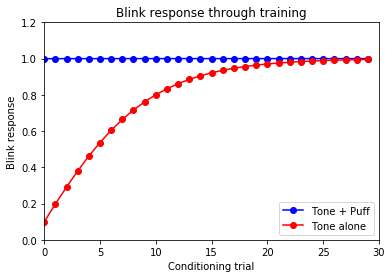

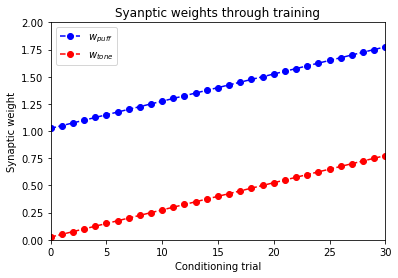

In [79]:
# Conditioning network


def set_inputs(p):
    """Sets the input"""
    global x_tone
    global x_swab
    
    x_tone = p[0]
    x_swab = p[1]

def activation():
    """Calculates activation"""
    global y_blink
    y_blink = np.tanh(gamma * (w_tb * x_tone + w_pb * x_swab))
    
def hebb():
    """Updates synaptic weights"""
    global w_pb
    global w_tb
    w_pb += eta * x_swab * y_blink
    w_tb += eta * x_tone * y_blink
    
train = []
test = []
w_pb_history = []
w_tb_history = []

def hebb_train(n = 30):
    """Conditioning paradigm"""
    for j in range(n):
        set_inputs(p_conditioning)
        activation()
        train.append(y_blink)
        
        hebb()
        
        set_inputs(p_test)
        activation()
        test.append(y_blink)
        
        w_pb_history.append(w_pb)
        w_tb_history.append(w_tb)


hebb_train()
plt.plot(train, "bo-")
plt.plot(test, "ro-")
plt.xlabel("Conditioning trial")
plt.ylabel("Blink response")
plt.title("Blink response through training")
plt.legend(["Tone + Puff", "Tone alone"], loc="best")
plt.axis([0, 30, 0, 1.2])
plt.show()


hebb_train()
plt.plot(w_pb_history, "bo--")
plt.plot(w_tb_history, "ro--")
plt.xlabel("Conditioning trial")
plt.ylabel("Synaptic weight")
plt.title("Syanptic weights through training")
plt.legend([r"$w_{puff}$", r"$w_{tone}$"], loc="best")
plt.axis([0, 30, 0, 2.0])
plt.show()


### Oja's rule

Oja's rule essentially adapts the weight matrix to extract the principal component of a number of vectors.

Here are the parameters

In [80]:
nx = 10
x = np.zeros((1, nx))
w = np.random.random(x.shape)/100
y = 0.0
eta = 0.05


And here a demonstration

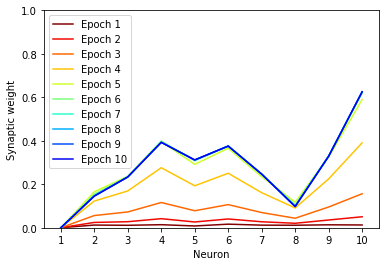

In [81]:

def generate_patterns(n=6):
    """Generates binary patterns"""
    patterns = []
    scale = np.array(np.arange(0.5, 2.0, 1.5/nx))
    scale = scale.reshape((1, nx))
    for i in range(n):
        p = np.random.random(x.shape)
        p *= scale
        p = np.round(p)
        patterns.append(p)
    return patterns

def set_inputs(p):
    global x
    x = np.array(p).reshape((1, nx))

def calculate_response(p):
    global y
    set_inputs(p)
    y = activation()
    return y

def activation():
    return linear(x.dot(w.T))

w_history = []

def oja(epochs=200):
    """Oja's rule"""
    global w, y
    for i in np.arange(epochs):
        for p in patterns:
            y = calculate_response(p)
            dw = eta * y * (x - w * y)
            w = w + dw
        w_history.append(w)


jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin = 0, vmax = 10)
scalarMap = cmx.ScalarMappable(norm = cNorm, cmap = jet)

patterns = generate_patterns()
oja(10)
#print w_history
for i in range(10):
    plt.plot(w_history[i].tolist()[0], color = scalarMap.to_rgba(10-i))
plt.ylabel("Synaptic weight")
plt.xlabel("Neuron")
plt.axis([-0.5, nx - 1/2, 0, 1])
plt.xticks(range(nx), ["%s" % (x+1) for x in range(nx)])
plt.legend(["Epoch %s" % (x+1) for x in range(10)], loc="best")
plt.show()